## Предсказание сердечных заболеваний

Буду сравнивать различные методы классификации и предсказывать наличе сердечных заболеваний

## 📊 Методы, которые буду рассматривать:
1. **Логистическая регрессия** - базовая линейная модель
2. **Деревья решений** - интерпретируемая нелинейная модель
3. **Случайный лес** - ансамблевый метод
4. **SVM (линейный и RBF)** - метод опорных векторов
5. **Наивный Байес** - вероятностный метод
6. **k-NN** - метод ближайших соседей

## 🔬 План исследования:
1. Загрузка и анализ данных
2. Исследовательский анализ данных (EDA)
3. Предобработка данных
4. Обучение и сравнение моделей
5. Анализ результатов и выводы

In [13]:
#Основные библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

#Машинное обучение
import sklearn
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                            roc_curve, roc_auc_score, precision_recall_curve)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Импорт моделей
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

#Импорт штук для гиперпараметрчиеской оптимизации
import optuna
from optuna.samplers import TPESampler
import time

#настройка для красивых графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Убираем лишние сообщения optuna

print('Все библиотеки успешно импортированы V')

Все библиотеки успешно импортированы V


# 1. Загрузка и первичный анализ данных

In [15]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

columns = [
    'age',           # возраст
    'sex',           # пол (1 = мужской, 0 = женский)
    'cp',            # тип боли в груди (1-4)
    'trestbps',      # давление в покое
    'chol',          # уровень холестерина
    'fbs',           # сахар в крови натощак > 120 мг/дл (1 = да, 0 = нет)
    'restecg',       # результаты ЭКГ в покое (0-2)
    'thalach',       # максимальная частота сердечных сокращений
    'exang',         # стенокардия, вызванная физической нагрузкой (1 = да, 0 = нет)
    'oldpeak',       # депрессия ST, вызванная физической нагрузкой
    'slope',         # наклон пикового сегмента ST (1-3)
    'ca',            # количество крупных сосудов, окрашенных флюороскопией (0-3)
    'thal',          # 3 = нормальный; 6 = фиксированный дефект; 7 = обратимый дефект
    'target'         # наличие сердечного заболевания (0 = нет, 1-4 = есть)
]

df = pd.read_csv(url, names=columns)
print('Размер датасета:', df.shape)
print('Первые 5 строк:')
df.head(5)

Размер датасета: (303, 14)
Первые 5 строк:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [16]:
df = df.drop( df[df['ca'] == '?'].index)
df = df.drop( df[df['thal'] == '?'].index)
df['ca'] = df['ca'].astype(float)
df['thal'] = df['thal'].astype(float)

#Анализ данных
print('Информация о датасете:')
print(df.info())

print()
print('Описательная статистика:')
print(df.describe())

print()
print('Пропуски в датасете:')
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

print()
print('Распределение целевой пременной Y:')
print(df['target'].value_counts())

print()
print('Уникальные значения в каждой колонке:')
for el in df.columns:
    print(f'{el}: {df[el].nunique()} уникальных значений')

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    float64
 1   sex       297 non-null    float64
 2   cp        297 non-null    float64
 3   trestbps  297 non-null    float64
 4   chol      297 non-null    float64
 5   fbs       297 non-null    float64
 6   restecg   297 non-null    float64
 7   thalach   297 non-null    float64
 8   exang     297 non-null    float64
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    float64
 11  ca        297 non-null    float64
 12  thal      297 non-null    float64
 13  target    297 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 34.8 KB
None

Описательная статистика:
              age         sex          cp    trestbps        chol         fbs  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean    

In [17]:
#Предобработка данных
print('Начинаем предобработку данных...')

#1. Обработкаа пропущенных значений
if df.isnull().sum().sum() > 0:
    print('\nОбнаружены пропущенные значения. Заполню медианой для числовых признаков')
    for col in df.columnso:
        if df[col].isnull().sum().sum() > 0:
            if df[col].dtype in ['int64 ', 'float64']:
                median_val = df[col].median()
                df[col].fillna(median_val, inplace=True)
                print(f'Колонка {col}: заполнено медианой {median_val}')
else:
    print('\nПропущенные значения не обнаружены')

#2. Преобразование целевой переменной в бинарную (0 -> 0, 1,2,3,4 -> 1)
print('\nПреобразуем целевую переменную Y в бинарную')
print(f'До: {df['target'].value_counts().to_dict()}')

df['target'] = (df['target'] > 0).astype(int)
print(f'После: {df['target'].value_counts().to_dict()}')

#3 Проверка типов данных (int/float)
print('\nФинальные типы данных:')
print(df.dtypes)

print('\nПредобработка завершена')

Начинаем предобработку данных...

Пропущенные значения не обнаружены

Преобразуем целевую переменную Y в бинарную
До: {0: 160, 1: 54, 2: 35, 3: 35, 4: 13}
После: {0: 160, 1: 137}

Финальные типы данных:
age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
target        int32
dtype: object

Предобработка завершена


# 2. Исследовательский анализ данных (EDA)

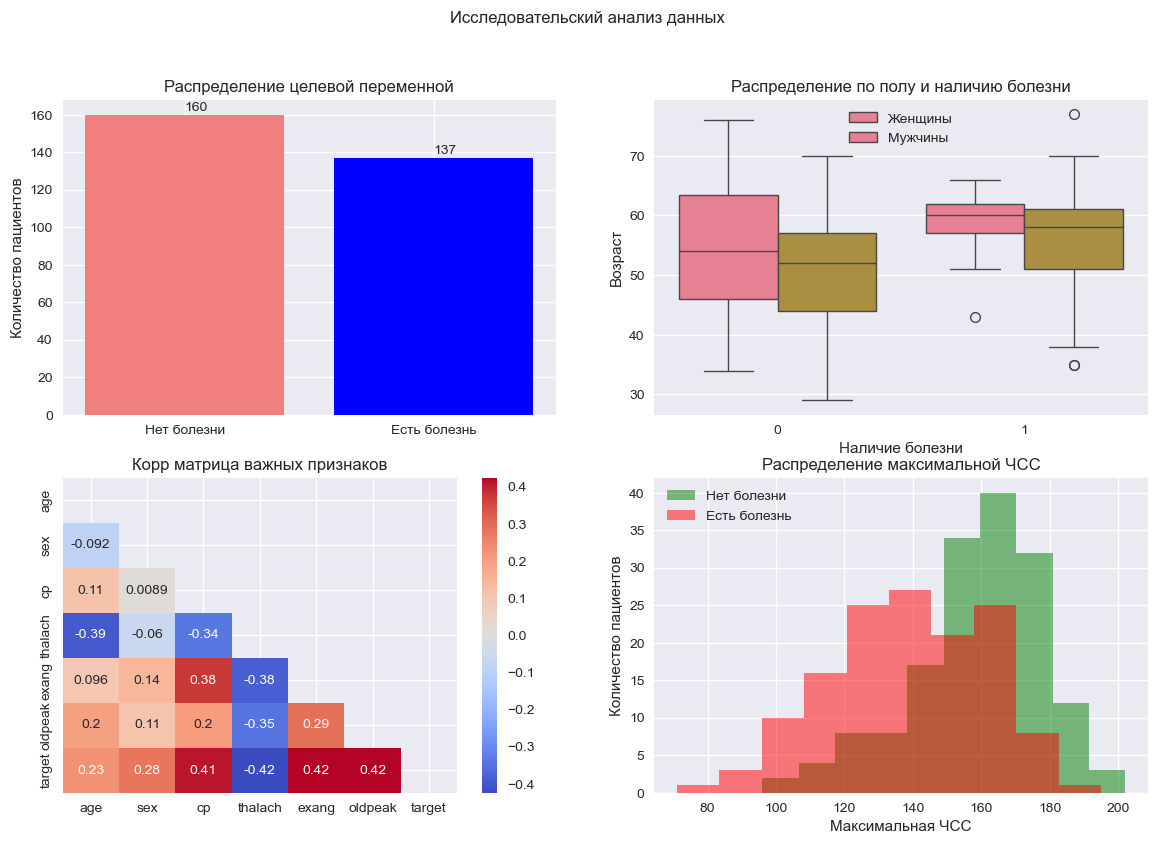

Данные сбалансированы: 160 без болезни, 137 с болезнью
Средний возраст человека с болезнью: 56.759
Средний возраст человека без болезни: 52.644
Корреляция между ca и target:, 0.463
Корреляция междук thal и target:, 0.527


In [19]:
fig = plt.figure(figsize=(14,9))
fig.suptitle('Исследовательский анализ данных')

#1. Распределение целевой переменной
ax1 = plt.subplot(221)
target_counts = df['target'].value_counts()
colors = ['lightcoral', 'blue']
bars = plt.bar(['Нет болезни', 'Есть болезнь'], target_counts.values, color=colors)
ax1.set_title('Распределение целевой переменной')
ax1.set_ylabel('Количество пациентов')
#Добавляем значения на столбцы
for bar, value in zip(bars, target_counts.values):
    ax1.text(bar.get_x() + bar.get_width() /2, bar.get_height() + 2, str(value))


#2. Распределение по полу и возрасту
ax2 = plt.subplot(222)
sns.boxplot(data=df, x='target', y='age', hue='sex')
ax2.set_title('Распределение по полу и наличию болезни')
ax2.set_xlabel('Наличие болезни')
ax2.set_ylabel('Возраст')
ax2.legend(['Женщины','Мужчины'])

#3. Корелляционая матрица
ax3 = plt.subplot(223)
features = ['age', 'sex', 'cp', 'thalach', 'exang', 'oldpeak', 'target']
corr_matrix = df[features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm')
ax3.set_title('Корр матрица важных признаков')

#4. Распределений максималаьной ЧСС
ax4 = plt.subplot(224)
df_no_disease = df[df['target'] == 0]['thalach']
df_disease = df[df['target'] == 1]['thalach']
ax4.hist(df_no_disease, color='green', alpha=0.5, label='Нет болезни')
ax4.hist(df_disease, color='red', alpha=0.5, label='Есть болезнь')
ax4.set_title('Распределение максимальной ЧСС')
ax4.set_xlabel('Максимальная ЧСС')
ax4.set_ylabel('Количество пациентов')
ax4.legend(labels=['Нет болезни', 'Есть болезнь'])
plt.show()

#Вывод
print(f'Данные сбалансированы: {target_counts[0]} без болезни, {target_counts[1]} с болезнью')
print(f'Средний возраст человека с болезнью: {df[df['target'] == 1]['age'].mean():.3f}')
print(f'Средний возраст человека без болезни: {df[df['target'] == 0]['age'].mean():.3f}')
print(f'Корреляция между ca и target:, {df['ca'].corr(df['target']):.3f}')
print(f'Корреляция междук thal и target:, {df['thal'].corr(df['target']):.3f}')

# 3. Подготовка данных к машинному обучению

In [21]:
print('Подготовка данных к машинному обучению...')

X = df.drop('target', axis=1)
y = df['target']

print()
print('Размеры признаков:', X.shape)
print('Размеры таргетов:', y.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

print()
print('Размеры X_train:', X_train.shape)
print('Размеры y_train::', X_test.shape)

#Масштабирование данных (Важно для Логистической регрессии, SVM и k-NN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
print('\nМасштабирование завершено')
print(f'Среднее значение после масштабирования: {X_train_scaled.mean():.3f}')
print(f'Среднее отклонение после масштабирования: {X_train_scaled.std():.3f}')

Подготовка данных к машинному обучению...

Размеры признаков: (297, 13)
Размеры таргетов: (297,)

Размеры X_train: (237, 13)
Размеры y_train:: (60, 13)

Масштабирование завершено
Среднее значение после масштабирования: -0.000
Среднее отклонение после масштабирования: 1.000


# 4. Обучение и сравнивание моделей

In [23]:
models = {
    'Логистическая регрессия': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'scaled': True,
        'description': 'Линейная модель с сигмоидной функцией'
    },
    'Дерево решений': {
        'model': DecisionTreeClassifier(random_state=42, max_depth=10),
        'scaled': False,
        'description': 'Построение дерева решений с правилами'
    },
    'Случайный лес': {
        'model': RandomForestClassifier(random_state=42, n_estimators=100),
        'scaled': False,
        'description':'Ансамбль деревьев решений'
    },
    'SVM (Линейный)': {
        'model': SVC(kernel='linear', random_state=42, probability=True),
        'scaled': True,
        'description': 'Линейная разделяющая плоскость'
    },
    'SVM (RBF)': {
        'model': SVC(kernel='rbf', random_state=42, probability=True),
        'scaled': True,
        'description': 'Нелинейная разделяющая плоскость'
    },
    'Наивный Байес': {
        'model': GaussianNB(),
        'scaled': False,
        'description': 'Вероятностная модель с предположением о независимости'
    },
    'k-NN': {
        'model': KNeighborsClassifier(n_neighbors=5),
        'scaled': True,
        'description': 'Классификация по ближайшим соседям'
    },
}

print('Созданы модели для обучения')
for name, info in models.items():
    scaled_text = "с масштабированием" if info['scaled'] == True else "без масштабирования"
    print(f'{name}: {info['description']} ({scaled_text})')

Созданы модели для обучения
Логистическая регрессия: Линейная модель с сигмоидной функцией (с масштабированием)
Дерево решений: Построение дерева решений с правилами (без масштабирования)
Случайный лес: Ансамбль деревьев решений (без масштабирования)
SVM (Линейный): Линейная разделяющая плоскость (с масштабированием)
SVM (RBF): Нелинейная разделяющая плоскость (с масштабированием)
Наивный Байес: Вероятностная модель с предположением о независимости (без масштабирования)
k-NN: Классификация по ближайшим соседям (с масштабированием)


In [24]:
#обучение и получение результатов
print('Начинаем обучение моделей...')

results = {}
trained_models = {}

for name, info in models.items():
    print(f'\nОбучение модели {name}')
    model = info['model']
    use_scaled = info['scaled']

    #Выбираем данные (scaled или обычные)
    if use_scaled:
        X_train_current = X_train_scaled
        X_test_current = X_test_scaled
    else:
        X_train_current = X_train
        X_test_current = X_test

    model.fit(X_train_current, y_train)

    #предсказания
    y_pred = model.predict(X_test_current)
    y_proba = model.predict_proba(X_test_current)[:, 1] if hasattr(model, 'predict_proba') else None

    #Кросс-валидация
    cv_scores = cross_val_score(model, X_train_current, y_train, cv=5, scoring='accuracy')

    #сохраняем результаты
    results[name] = {
    'accuracy': accuracy_score(y_test, y_pred),
    'cv_scores': cv_scores,
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std(),
    'predictions': y_pred,
    'probability': y_proba
    }

    #сохраняем обученную модель
    trained_models[name] = model
    print(f'Accuracy: {results[name]['accuracy']}')
    print(f'CV_Score: {results[name]['cv_mean']}')

print('Обучение моделей завершено')

Начинаем обучение моделей...

Обучение модели Логистическая регрессия
Accuracy: 0.8333333333333334
CV_Score: 0.8220744680851064

Обучение модели Дерево решений
Accuracy: 0.7
CV_Score: 0.737677304964539

Обучение модели Случайный лес
Accuracy: 0.85
CV_Score: 0.8180851063829786

Обучение модели SVM (Линейный)
Accuracy: 0.8333333333333334
CV_Score: 0.826418439716312

Обучение модели SVM (RBF)
Accuracy: 0.8333333333333334
CV_Score: 0.8135638297872341

Обучение модели Наивный Байес
Accuracy: 0.8833333333333333
CV_Score: 0.8179964539007093

Обучение модели k-NN
Accuracy: 0.8166666666666667
CV_Score: 0.7968085106382978
Обучение моделей завершено


# 5. Анализ и визуализация результатов

In [26]:
results_df = pd.DataFrame({
    'Модель': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'CV Mean': [results[name]['cv_mean'] for name in results.keys()],
    'CV Std': [results[name]['cv_std'] for name in results.keys()],
    'Описание': [models[name]['description'] for name in results.keys()],
})
results_df = results_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print('РЕЗУЛЬТАТЫ')
print('=' * 80)
print(results_df.to_string(index=False, float_format='%.3f'))

print('Лучшая модель по Accuracy:', results_df.iloc[0,0])
print('Вторая модель по Accuracy:', results_df.iloc[1]['Модель'])
print('Третья модель по Accuracy:', results_df.iloc[2,0])

РЕЗУЛЬТАТЫ
                 Модель  Accuracy  CV Mean  CV Std                                              Описание
          Наивный Байес     0.883    0.818   0.059 Вероятностная модель с предположением о независимости
          Случайный лес     0.850    0.818   0.060                             Ансамбль деревьев решений
Логистическая регрессия     0.833    0.822   0.076                 Линейная модель с сигмоидной функцией
         SVM (Линейный)     0.833    0.826   0.077                        Линейная разделяющая плоскость
              SVM (RBF)     0.833    0.814   0.096                      Нелинейная разделяющая плоскость
                   k-NN     0.817    0.797   0.103                    Классификация по ближайшим соседям
         Дерево решений     0.700    0.738   0.087                 Построение дерева решений с правилами
Лучшая модель по Accuracy: Наивный Байес
Вторая модель по Accuracy: Случайный лес
Третья модель по Accuracy: Логистическая регрессия


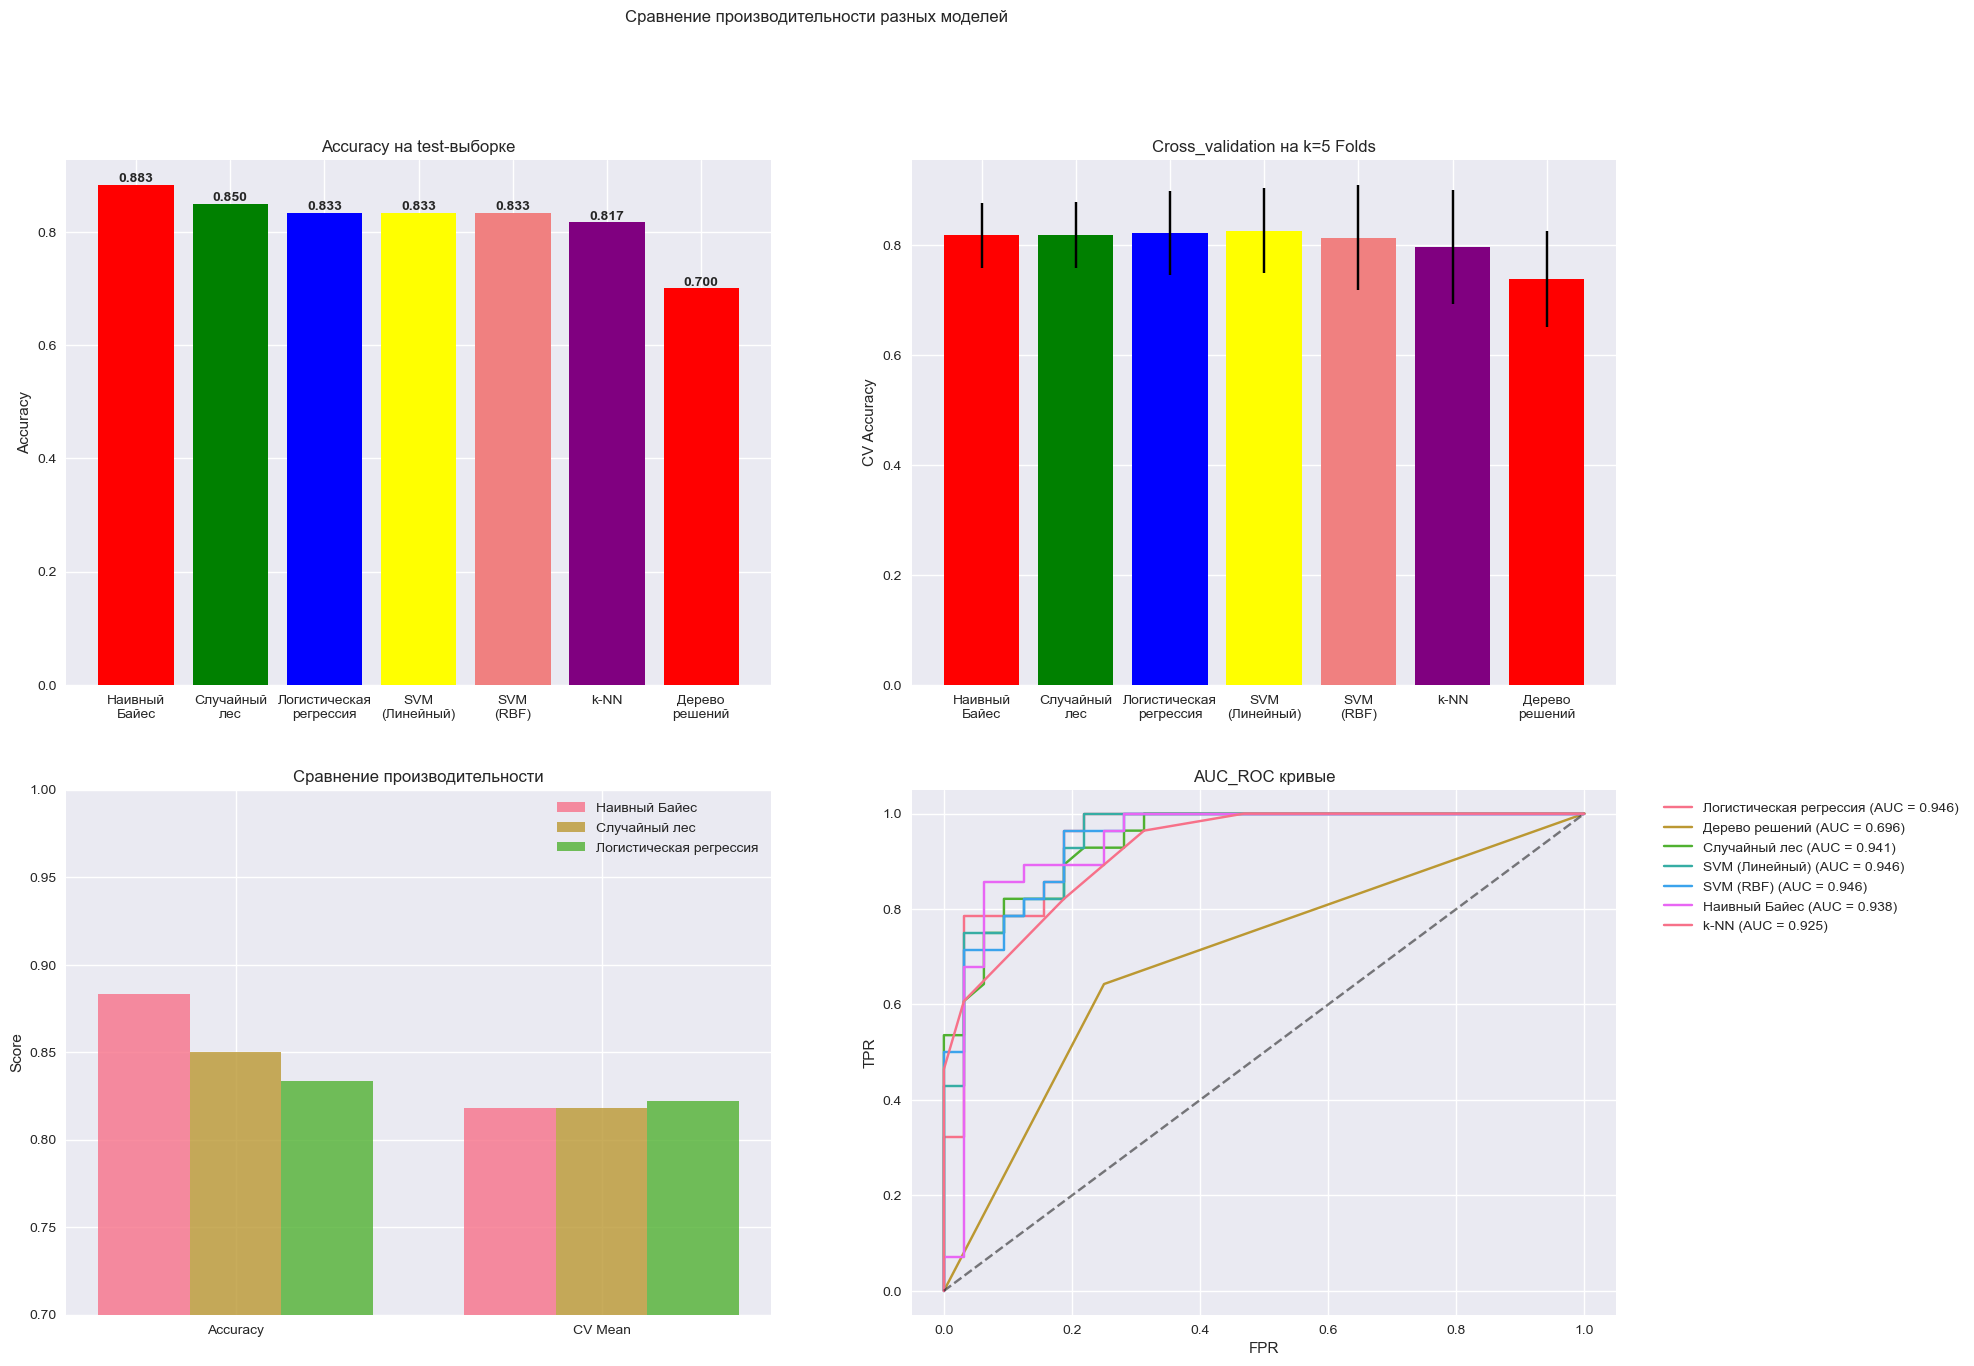

In [27]:
#Создаем красивую визуализацию результатов
fig = plt.figure(figsize=(20,15))
fig.suptitle('Сравнение производительности разных моделей')

#1 Сравнение Accuracy
ax1 = plt.subplot(221)
ax1.set_title('Accuracy на test-выборке')
colors = ['red', 'green', 'blue', 'yellow', 'lightcoral', 'purple']
names = [el.replace(' ', '\n') for el in results_df['Модель']]
bars = plt.bar(names, results_df['Accuracy'], color=colors)

for bar, value in zip(bars, results_df['Accuracy']):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(f'{value:.3f}'),
            ha = 'center', va = 'bottom', fontweight='bold')

ax1.set_ylabel('Accuracy')
    
#2 Cross-validation scores
ax2 = plt.subplot(222)
ax2.set_title('Cross_validation на k=5 Folds')
bars2 = plt.bar(names, results_df['CV Mean'], yerr=results_df['CV Std'], color=colors, capsize=5)
ax2.set_ylabel('CV Accuracy')

#3 Сравнение производительности
ax3 = plt.subplot(223)
ax3.set_title('Сравнение производительности')
metrics = ['Accuracy', 'CV Mean']
top3 = results_df.head(3)
x = np.arange(len(metrics))
width = 0.25

for i, (_, row) in enumerate(top3.iterrows()):
    values = [row['Accuracy'], row['CV Mean']]
    ax3.bar(x + i*width, values, width, label=row['Модель'], alpha=0.8)

ax3.set_xticks(x + width)
ax3.set_xticklabels(metrics)
ax3.set_ylabel('Score')
ax3.legend()
ax3.set_ylim(0.7, 1.0)
#4 ROC-Curves для моделей с probability
ax4 = plt.subplot(224)
ax4.set_title('AUC_ROC кривые')
for name in results.keys():
    if results[name]['probability'] is not None:
        fpr, tpr, _ = roc_curve(y_test, results[name]['probability'])
        auc_score = roc_auc_score(y_test, results[name]['probability'])
        ax4.plot(fpr,tpr, label=f'{name} (AUC = {auc_score:.3f})')

ax4.set_xlabel('FPR')
ax4.set_ylabel('TPR')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.show()

# Дополнительная статистика


# Оптимизация через библиотеку Optuna

In [135]:
def optimize_logistic_regression(trial, X_train, y_train):
    #Оптимизация гиперпараметров логистической регрессии
    params = {
        'C': trial.suggest_float('C', 0.01, 100, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet']),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'max_iter': 200,
        'random_state': 42
    }

    if params['penalty'] == 'elasticnet':
        params['l1_ratio'] = trial.suggest_float('l1_ratio', 0, 1)
        params['solver'] = 'saga'

    if params['penalty'] == 'elasticnet' and params['solver'] == 'liblinear':
        params['solver'] = 'saga'

    model = LogisticRegression(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()

def optimize_decision_tree(trial, X_train, y_train):
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }

    model = DecisionTreeClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()

def optimize_random_forest(trial, X_train, y_train):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()

def optimize_svm_linear(trial, X_train, y_train):
    params = {
        'C': trial.suggest_float('C', 0.01, 100, log=True),
        'kernel': 'linear',
        'probability': True,
        'random_state': 42
    }
    
    model = SVC(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()

def optimize_svm_rbf(trial, X_train, y_train):
    params = {
        'C': trial.suggest_float('C', 0.01, 100, log=True),
        'gamma': trial.suggest_float('gamma', 1e-6, 1e-1, log=True),
        'kernel': 'rbf',
        'probability': True,
        'random_state': 42
    }
    
    model = SVC(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()


def optimize_naive_bayes(trial, X_train, y_train):
    params = {
        'var_smoothing': trial.suggest_float('var_smoothing', 1e-12, 1e-6, log=True)
    }
    
    model = GaussianNB(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()


def optimize_knn(trial, X_train, y_train):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 15),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski']),
        'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    }
    
    if params['metric'] == 'minkowski':
        params['p'] = trial.suggest_int('p', 1, 3)
    
    model = KNeighborsClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()

print('Функции оптимизации гиперпараметров моделей созданы успешно')

Функции оптимизации гиперпараметров моделей созданы успешно


In [139]:
#Вся оптимизация тут
N_TRAILS = 100 #количество попыток оптимизации для каждой модели
TIMEOUT = 300 #5 minutes * 60 seconds = 300 seconds

#словарь с функциями чтобы использовать их как object-обертки для Optuna
optimization_functions = {
    'Логистическая регрессия': optimize_logistic_regression,
    'Дерево решений': optimize_decision_tree,
    'Случайный лес': optimize_random_forest,
    'SVM (Линейный)': optimize_svm_linear,
    'SVM (RBF)': optimize_svm_rbf,
    'Наивный Байес': optimize_naive_bayes,
    'k-NN': optimize_knn
}

print('Начинаем оптимизацию гиперпараметров...')
print(f'Дадим на каждую модель {N_TRAILS} попыток и {TIMEOUT // 60} минут')

optimized_results = {}
optimization_studies = {}
optimization_times = {}

start_total_time = time.time()

print()
for name, opt_function in optimization_functions.items():
    print(f'Оптимизируем модель {name}')
    start_time = time.time()

    use_scaled = models[name]['scaled']
    if use_scaled:
        X_train_opt = X_train_scaled
        X_test_opt = X_test_scaled
    else:
        X_train_opt = X_train
        X_test_opt = X_test

    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
    study.optimize(lambda trial: opt_function(trial, X_train_opt, y_train), n_trials = N_TRAILS, timeout=TIMEOUT, show_progress_bar=False)

    end_time = time.time()
    optimization_time = end_time - start_time
    optimization_times[name] = optimization_time

    optimization_studies[name] = study

    best_params = study.best_params
    best_score = study.best_value

    print(f'Завершено за {optimization_time}')
    print(f'Лучшие параметры: {best_params}')
    print(f'Лучший Score: {best_score}')
    print()


    if name == 'Логистическая регрессия':
        optimized_model = LogisticRegression(**best_params)
    if name == 'Дерево решений':
        optimized_model = DecisionTreeClassifier(**best_params)
    if name == 'Случайный лес':
        optimized_model = RandomForestClassifier(**best_params)
    if name == 'SVM (Линейный)':
        optimized_model = SVC( **best_params)
    if name == 'SVM (RBF)':
        optimized_model = SVC(**best_params)
    if name == 'Наивный Байес':
        optimized_model = GaussianNB(**best_params)
    if name == 'k-NN':
        optimized_model = KNeighborsClassifier(**best_params)

    optimized_model.fit(X_train_opt, y_train)
    y_pred_opt = optimized_model.predict(X_test_opt)
    y_pred_proba_opt = optimized_model.predict_proba(X_test_opt)[:,1] if hasattr(optimized_model, 'predict_proba') else None

    cv_scores_opt = cross_val_score(optimized_model, X_train_opt, y_train, cv=5, scoring='accuracy')

    optimized_results[name] = {
        'best_params': best_params,
        'best_cv_score': best_score,
        'test_accuracy': accuracy_score(y_test, y_pred_opt),
        'cv_mean': cv_scores_opt.mean(),
        'cv_std': cv_scores_opt.std(),
        'predictions': y_pred_opt,
        'probabilities': y_pred_proba_opt,
        'n_trials': len(study.trials),
        'optimization_time': optimization_time,
        'model': optimized_model
    }

    total_time = time.time() - start_total_time
print(f"\n🎉 ОПТИМИЗАЦИЯ ЗАВЕРШЕНА!")
print(f"⏱️ Общее время: {total_time:.1f} секунд ({total_time/60:.1f} минут)")
print(f"🔍 Общее количество попыток: {sum(len(study.trials) for study in optimization_studies.values())}")

Начинаем оптимизацию гиперпараметров...
Дадим на каждую модель 100 попыток и 5 минут

Оптимизируем модель Логистическая регрессия
Завершено за 2.369976758956909
Лучшие параметры: {'C': 0.020841758757268448, 'penalty': 'l2', 'solver': 'saga'}
Лучший Score: 0.8431737588652484

Оптимизируем модель Дерево решений
Завершено за 4.601811647415161
Лучшие параметры: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': None}
Лучший Score: 0.8180851063829786

Оптимизируем модель Случайный лес
Завершено за 148.2450623512268
Лучшие параметры: {'n_estimators': 256, 'criterion': 'gini', 'max_depth': 14, 'min_samples_split': 13, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False}
Лучший Score: 0.8558510638297872

Оптимизируем модель SVM (Линейный)
Завершено за 11.217252492904663
Лучшие параметры: {'C': 0.010060835470775855}
Лучший Score: 0.8431737588652481

Оптимизируем модель SVM (RBF)
Завершено за 6.439440965652466
Лучшие параметры: 